# ***Assignment 1.3 - CAVI***
Consider the model defined by Equation (10.21)-(10-23) in Bishop, for which DGM is presented below:

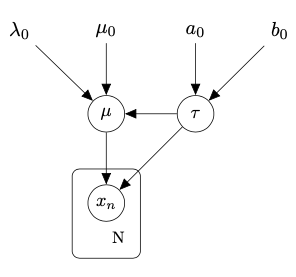

### ***Question 1.3.12:***

Implement a function that generates data points for the given model.

In [131]:
import numpy as np
def generate_data(mu, tau, N):
  # Insert your code here
  D = np.random.normal(mu, 1/tau, N)

  return D


Set μ = 1, τ = 0.5 and generate datasets with size N=10,100,1000. Plot the histogram for each of 3
datasets you generated.



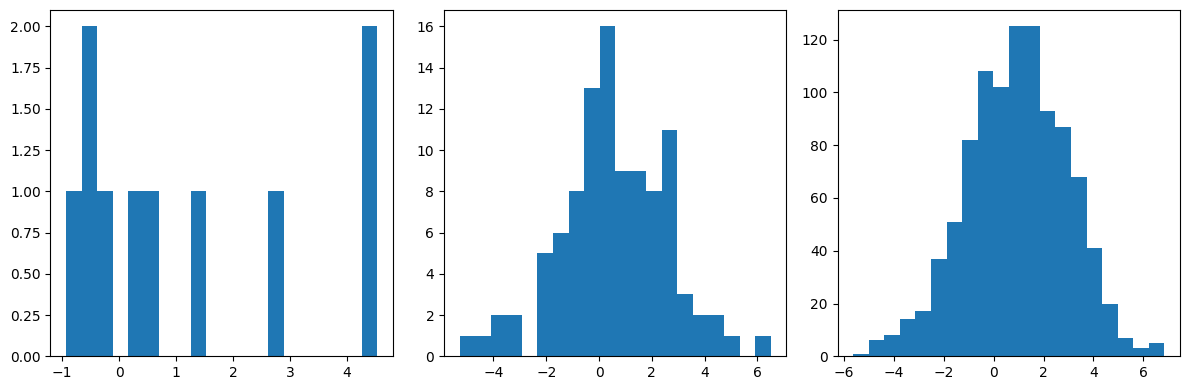

In [132]:
mu = 1
tau = 0.5

dataset_1 = generate_data(mu, tau, 10)
dataset_2 = generate_data(mu, tau, 100)
dataset_3 = generate_data(mu, tau, 1000)

# Visulaize the datasets via histograms
# Insert your code here
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].hist(dataset_1, bins=20)
axs[1].hist(dataset_2, bins=20)
axs[2].hist(dataset_3, bins=20)
plt.tight_layout()
plt.savefig('12_data.png')
plt.show()

### ***Question 1.3.13:***

Find ML estimates of the variables μ and τ

In [133]:
def ML_est(data):
    # insert your code
    N = len(data)
    x_mean = np.mean(data)
    x_var = np.var(data, ddof=1)

    tau_ml = 1 / (N * x_var)
    mu_ml = x_mean

    return mu_ml, tau_ml

### ***Question 1.3.14:***

What is the exact posterior? First derive it in closed form, and then implement a function that computes it for the given parameters:


In [134]:
def compute_exact_posterior(D, a_0, b_0, mu_0, lambda_0):
    # your implementation
    x_mean = np.mean(D)
    N = len(D)

    mu_prime = (lambda_0 * mu_0 + N * x_mean) / (lambda_0 + N)
    lambda_prime = lambda_0 + N
    a_prime = a_0 + N / 2
    b_prime = b_0 + 1 / 2 * (np.sum((D - x_mean)**2) +
                             lambda_0 * mu_0**2 - lambda_prime * mu_prime**2)

    exact_post_distribution = (a_prime, b_prime, mu_prime, lambda_prime)

    return exact_post_distribution

### ***Question 1.3.15:***
You will implement the VI algorithm for the variational distribution in Equation (10.24) in Bishop. Start with introducing the prior parameters:

In [135]:
# prior parameters
mu_0 = 0
lambda_0 = 1
a_0 = 1
b_0 = 1

Continue with a helper function that computes ELBO:


In [136]:
from scipy.stats import gamma, norm, multivariate_normal
from scipy.special import psi
eps = 1e-6

def compute_elbo(D, a_0, b_0, mu_0, lambda_0, a_N, b_N, mu_N, lambda_N):
    N = len(D)
    x_mean = np.mean(D)
    x_2_sum = np.sum(D**2)

    # Expected log likelihood
    expected_log_likelihood = 0.5 * N * (np.log(lambda_N) - np.log(
        2 * np.pi)) - 0.5 * lambda_N * (x_2_sum - 2 * x_mean * mu_N * N + N * mu_N**2)

    # Expected log prior for mu
    expected_log_prior_mu = 0.5 * (np.log(lambda_0) - np.log(2 * np.pi)) - \
        0.5 * lambda_0 * (mu_N**2 - 2 * mu_N * mu_0 + mu_0**2)

    # Expected log prior for tau
    expected_log_prior_tau = a_0 * np.log(b_0) - np.log(gamma(a_0).pdf(0)) + (
        a_0 - 1) * (psi(a_N) - np.log(b_N)) - b_0 * (a_N / b_N)

    # Entropy of variational distribution for mu
    entropy_mu = 0.5 * (1 + np.log(2 * np.pi)) + 0.5 * np.log(1 / lambda_N)

    # Entropy of variational distribution for tau
    entropy_tau = a_N - np.log(b_N) + \
        np.log(gamma(a_N).pdf(0) + eps) + (1 - a_N) * psi(a_N)

    # Compute ELBO
    elbo = expected_log_likelihood + expected_log_prior_mu + \
        expected_log_prior_tau + entropy_mu + entropy_tau

    return elbo

Now, implement the CAVI algorithm:

In [137]:
def CAVI(D, a_0, b_0, mu_0, lambda_0, iter=10):
  # make an initial guess for the expected value of tau
  initial_guess_exp_tau = 1

  N = len(D)
  x_mean = np.mean(D)
  x_2_sum = np.sum(D**2)

  # Constants
  a_N = a_0 + N / 2
  mu_N = (lambda_0 * mu_0 + N * x_mean) / (lambda_0 + N)
  E_mu = mu_N
  
  # Variational parameters
  b_N = b_0
  lambda_N = lambda_0

  # ELBO
  elbos = []

  # CAVI iterations ...
  for i in range(iter):
    # update the values for the variational parameters
    E_tau = a_N / b_N 
    E_mu_2 = 1 / lambda_N + mu_N**2

    lambda_N = (lambda_0 + N) * E_tau
    b_N = b_0 + 1 / 2 * (x_2_sum + N*E_mu_2 - 2*N*E_mu*x_mean + lambda_0*(E_mu_2 - 2*E_mu*mu_0 + mu_0**2))
    # save ELBO for each iteration, plot them afterwards to show convergence
    elbos.append(compute_elbo(D, a_0, b_0, mu_0, lambda_0, a_N , b_N, mu_N, lambda_N))

  return a_N, b_N, mu_N, lambda_N, elbos

### ***Question 1.3.15:***
Run the VI algorithm on the datasets. Compare the inferred variational
distribution with the exact posterior and the ML estimate. Visualize the results and discuss your
findings.



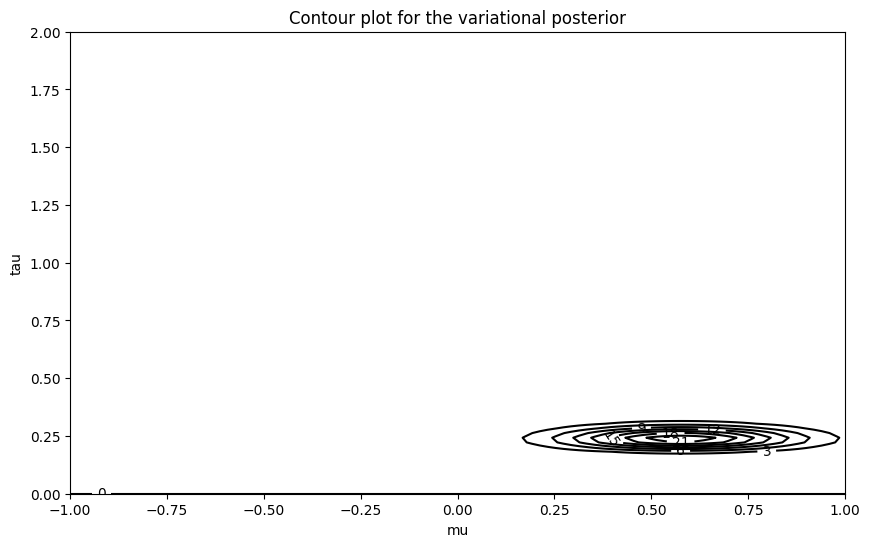

mu_ml:  0.5823418160580119
tau_ml:  0.002392399911410521
a_N:  51.0
b_N:  210.13321921599922
mu_N:  0.5765760555029822
lambda_N:  24.513020872111966
expected tau:  0.24270317749035342
exact_post_dist (a, b, mu, lambda):  (51.0, 191.11699009811133, 0.5765760555029822, 101)
exact expected tau:  0.26685225616947383


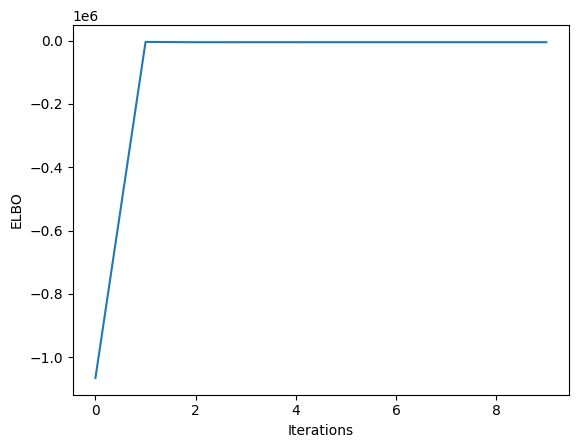

In [138]:
# Insert your main code here

mu_ml, tau_ml = ML_est(dataset_2)
a_N, b_N, mu_N, lambda_N, elbos = CAVI(dataset_2, a_0, b_0, mu_0, lambda_0)
exact_post_dist = compute_exact_posterior(dataset_2, a_0, b_0, mu_0, lambda_0)



mu_vals = np.linspace(-1, 1, 100)
tau_vals = np.linspace(0, 2, 100)
mu_grid, tau_grid = np.meshgrid(mu_vals, tau_vals)

# Calculate the Z values for contours
def calculate_density(mu, tau, mu_0, lambda_0, a_0, b_0):
    mu_prior = norm(mu_0, 1/np.sqrt(lambda_0)).pdf(mu)
    tau_prior = gamma(a_0, scale=1/b_0).pdf(tau)
    return mu_prior * tau_prior


Z = np.zeros_like(mu_grid)
for i in range(mu_grid.shape[0]):
    for j in range(mu_grid.shape[1]):
        Z[i, j] = calculate_density(
            mu_grid[i, j], tau_grid[i, j], mu_N, lambda_N, a_N, b_N)

# Plot the contour
plt.figure(figsize=(10, 6))
contour = plt.contour(mu_grid, tau_grid, Z, colors='k')
plt.clabel(contour, inline=1, fontsize=10)
plt.xlabel('mu')
plt.ylabel('tau')
plt.title('Contour plot for the variational posterior')
plt.show()





print('mu_ml: ', mu_ml)
print('tau_ml: ', tau_ml)
print('a_N: ', a_N)
print('b_N: ', b_N)
print('mu_N: ', mu_N)
print('lambda_N: ', lambda_N)
print('expected tau: ', a_N / b_N)
print('exact_post_dist (a, b, mu, lambda): ', exact_post_dist)
print('exact expected tau: ', exact_post_dist[0] / exact_post_dist[1])

# Plot ELBOs
plt.plot(elbos)
plt.xlabel('Iterations')
plt.ylabel('ELBO')
# plt.savefig('elbo.png')
plt.show()




# Example flow for dataset_2:



  ##  mu_ml, tau_ml = ML_est(dataset_2)



  ##  a_N, b_N, mu_N, lambda_N, elbos = CAVI(dataset_2, a_0, b_0, mu_0, lambda_0)



  ##  plot elbos, show convergence



  ##  exact_post_dist = compute_exact_posterior(dataset_2, a_0, b_0, mu_0, lambda_0)



  ##  compare exact_post_dist with the CAVI result ( = q(a_N, b_N, mu_N, lambda_N) ) using for ex. contour plots, show also ML estimate on this plot